In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet('daily_weather.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27635763 entries, 0 to 24220
Data columns (total 14 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   station_id              category      
 1   city_name               category      
 2   date                    datetime64[us]
 3   season                  category      
 4   avg_temp_c              float64       
 5   min_temp_c              float64       
 6   max_temp_c              float64       
 7   precipitation_mm        float64       
 8   snow_depth_mm           float64       
 9   avg_wind_dir_deg        float64       
 10  avg_wind_speed_kmh      float64       
 11  peak_wind_gust_kmh      float64       
 12  avg_sea_level_pres_hpa  float64       
 13  sunshine_total_min      float64       
dtypes: category(3), datetime64[us](1), float64(10)
memory usage: 2.6 GB


In [3]:
#filter Stockholm city
stockholm_data = df[df['city_name'] == 'Stockholm']

#select features
filtered_df = stockholm_data[['date', 'season','avg_temp_c', 'min_temp_c', 'max_temp_c', 
                              'precipitation_mm', 'avg_wind_dir_deg', 
                              'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa', 
                              'snow_depth_mm']]

#extract month, day, and year from the date
filtered_df['month'] = filtered_df['date'].dt.month
filtered_df['day'] = filtered_df['date'].dt.day
filtered_df['year'] = filtered_df['date'].dt.year

#removes any rows in filtered_df that contain missing values
filtered_df=filtered_df.dropna()
#preview data
filtered_df.head()

C:\Users\alvar\AppData\Local\Temp\ipykernel_720\1480438955.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['month'] = filtered_df['date'].dt.month
C:\Users\alvar\AppData\Local\Temp\ipykernel_720\1480438955.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['day'] = filtered_df['date'].dt.day
C:\Users\alvar\AppData\Local\Temp\ipykernel_720\1480438955.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa,snow_depth_mm,month,day,year
58806,2021-01-02,Winter,0.8,0.7,2.9,1.6,50.0,5.8,1016.1,0.0,1,2,2021
58807,2021-01-03,Winter,-0.6,-1.2,1.3,0.2,331.0,10.7,1026.8,0.0,1,3,2021
58808,2021-01-04,Winter,-0.1,-1.2,0.9,0.0,21.0,10.8,1029.6,0.0,1,4,2021
58809,2021-01-05,Winter,-0.8,-1.7,0.7,0.0,34.0,10.4,1030.3,0.0,1,5,2021
58810,2021-01-06,Winter,-2.7,-3.1,-0.3,0.4,35.0,12.4,1024.3,0.0,1,6,2021


In [4]:
features = filtered_df
#exclude some features
X = features.drop(['snow_depth_mm', 'date', 'season', 'year'], axis=1)
print(X.shape)
#assigning target variable to y
y = filtered_df[['snow_depth_mm']]

(905, 9)


In [5]:
#initialize scaler, scales data between 0 and 1
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [13]:
#look_back: number of past data points for making a prediction ("memory" of LSTM model)
def create_sequences(X, y, look_back=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - look_back):
        X_seq.append(X[i:i+look_back])
        y_seq.append(y[i+look_back])
    return np.array(X_seq), np.array(y_seq)

look_back = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, look_back)


In [14]:
#split data - training and testing
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [15]:
#define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Regularization
model.add(Dense(1))  # Output layer (predicting snow depth)

#compile model
model.compile(optimizer='adam', loss='mean_squared_error')

#train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0684 - val_loss: 0.0241
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0231 - val_loss: 0.0196
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0200 - val_loss: 0.0178
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0148 - val_loss: 0.0159
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0157 - val_loss: 0.0134
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 - val_loss: 0.0126
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119 - val_loss: 0.0100
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0122 - val_loss: 0.0099
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105 - val_loss: 0.0087
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0081
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0110
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0101 - val_loss: 0.0105

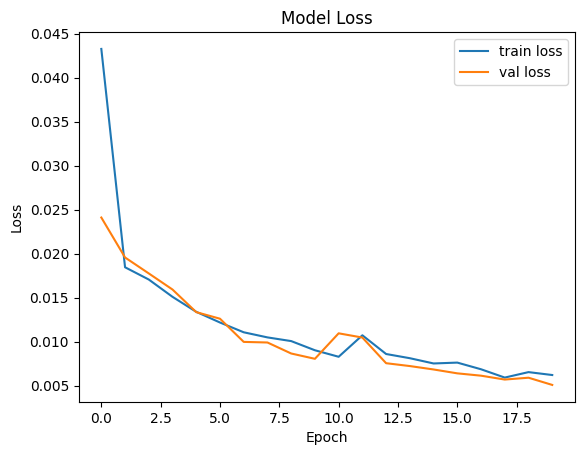

In [16]:
#visualize the training process
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [17]:
#evaluate model on test data
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075
Test Loss: 0.005093698389828205


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


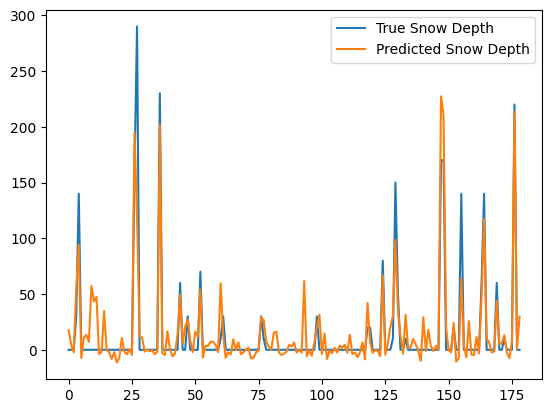

In [18]:
#make predictions
y_pred_scaled = model.predict(X_test)

#inverse transform the scaled predictions and true values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

#compare predicted snow depth with actual snow depth
plt.plot(y_test_original, label='True Snow Depth')
plt.plot(y_pred, label='Predicted Snow Depth')
plt.legend()
plt.show()